<a href="https://colab.research.google.com/github/LukmaanViscomi/AI-Deep-Learning/blob/main/Baseline_Controlled_V2_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### PHASE-1 - UNZIP THE DATA

### New Section

In [1]:
!apt-get install p7zip-full # Install 7-Zip
!pip install patool # Install the patool library which provides the patoolib module
import zipfile
import os
import patoolib # Now you can import patoolib

# Path to the uploaded zip file
zip_file_path = 'dataset2 (1).zip'
extracted_folder_path = './dataset2'  # Use a relative path for the extraction directory

# Extract the zip file using patool
patoolib.extract_archive(zip_file_path, outdir=extracted_folder_path)

# List the contents of the extracted folder
extracted_files = os.listdir(extracted_folder_path)
print(extracted_files)

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
p7zip-full is already the newest version (16.02+dfsg-8).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.6/96.6 kB 3.3 MB/s eta 0:00:00


INFO patool: Extracting dataset2 (1).zip ...
INFO:patool:Extracting dataset2 (1).zip ...
INFO patool: ... creating output directory `./dataset2'.
INFO:patool:... creating output directory `./dataset2'.
INFO patool: running /usr/bin/7z x -o./dataset2 -- "dataset2 (1).zip"
INFO:patool:running /usr/bin/7z x -o./dataset2 -- "dataset2 (1).zip"
INFO patool:     with input=''
INFO:patool:    with input=''
INFO patool: ... dataset2 (1).zip extracted to `./dataset2'.
INFO:patool:... dataset2 (1).zip extracted to `./dataset2'.


['triple_mnist']


### PHASE-2 - REDISTRIBUTE THE DATASET FOR TRAIN-VAL-TEST

In [2]:
import os
import shutil
from pathlib import Path
import random

# Paths to original directories
original_base_dir = Path('dataset2/triple_mnist')
original_train_dir = original_base_dir / 'train'
original_val_dir = original_base_dir / 'val'
original_test_dir = original_base_dir / 'test'

# Path to the new dataset directory
new_base_dir = Path('dataset-c/triple_mnist')
new_train_dir = new_base_dir / 'train'
new_val_dir = new_base_dir / 'val'
new_test_dir = new_base_dir / 'test'

# Ensure the new directories exist
new_train_dir.mkdir(parents=True, exist_ok=True)
new_val_dir.mkdir(parents=True, exist_ok=True)
new_test_dir.mkdir(parents=True, exist_ok=True)

# Function to split and copy files
def split_and_copy_files(src_dir, new_train_dir, new_val_dir, new_test_dir, train_ratio=0.6, val_ratio=0.2, test_ratio=0.2):
    if not src_dir.exists():
        return

    classes = sorted(os.listdir(src_dir))

    for cls in classes:
        cls_path = src_dir / cls
        if cls_path.is_dir():
            images = list(cls_path.glob('*'))
            random.shuffle(images)

            num_train = int(len(images) * train_ratio)
            num_val = int(len(images) * val_ratio)

            train_images = images[:num_train]
            val_images = images[num_train:num_train+num_val]
            test_images = images[num_train+num_val:]

            cls_train_dir = new_train_dir / cls
            cls_val_dir = new_val_dir / cls
            cls_test_dir = new_test_dir / cls

            cls_train_dir.mkdir(parents=True, exist_ok=True)
            cls_val_dir.mkdir(parents=True, exist_ok=True)
            cls_test_dir.mkdir(parents=True, exist_ok=True)

            for img in train_images:
                shutil.copy(str(img), str(cls_train_dir / img.name))
            for img in val_images:
                shutil.copy(str(img), str(cls_val_dir / img.name))
            for img in test_images:
                shutil.copy(str(img), str(cls_test_dir / img.name))

# Split and copy files from original train, val, and test directories
split_and_copy_files(original_train_dir, new_train_dir, new_val_dir, new_test_dir)
split_and_copy_files(original_val_dir, new_train_dir, new_val_dir, new_test_dir)
split_and_copy_files(original_test_dir, new_train_dir, new_val_dir, new_test_dir)

print("Files split and copied successfully!")

Files split and copied successfully!


### PHASE-3 - BUILD THE MODEL

### VERISON 2.0 - parralel runner!!

### Install and Imports

In [3]:
!pip install keras-tuner

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt
import os
import shutil
import random
import matplotlib.pyplot as plt
import pandas as pd

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 5.0 MB/s eta 0:00:00


### 1. Function to create a small subset of the dataset

In [4]:
### 1. Function to create a small subset of the dataset
def create_subset(original_dir, subset_dir, classes, num_images_per_class):
    if not os.path.exists(subset_dir):
        os.makedirs(subset_dir)
    for class_name in classes:
        class_dir = os.path.join(original_dir, class_name)
        subset_class_dir = os.path.join(subset_dir, class_name)
        if not os.path.exists(subset_class_dir):
            os.makedirs(subset_class_dir)
        images = os.listdir(class_dir)
        random.shuffle(images)
        for img in images[:num_images_per_class]:
            shutil.copy(os.path.join(class_dir, img), os.path.join(subset_class_dir, img))



### 2. Paths to your full dataset


In [5]:
### 2. Paths to your full dataset
full_train_dir = 'dataset-c/triple_mnist/train'
full_val_dir = 'dataset-c/triple_mnist/val'
full_test_dir = 'dataset-c/triple_mnist/test'

### 3. Paths to your subset dataset


In [6]:
### 3. Paths to your subset dataset
subset_train_dir = 'subset/triple_mnist/train'
subset_val_dir = 'subset/triple_mnist/val'
subset_test_dir = 'subset/triple_mnist/test'

### 4. Create a small subset of your data


In [7]:
### 4. Create a small subset of your data
classes_to_use = ['000', '001', '002']  # Example classes
num_images_per_class = 50  # Example number of images per class
create_subset(full_train_dir, subset_train_dir, classes_to_use, num_images_per_class)
create_subset(full_val_dir, subset_val_dir, classes_to_use, num_images_per_class)
create_subset(full_test_dir, subset_test_dir, classes_to_use, num_images_per_class)

### 5. Image data generators for the subset


In [8]:
### 5. Image data generators for the subset
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

### 6. Data generators for the subset


In [9]:
### 6. Data generators for the subset
train_generator = train_datagen.flow_from_directory(
    subset_train_dir,
    target_size=(84, 84),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    subset_val_dir,
    target_size=(84, 84),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    subset_test_dir,
    target_size=(84, 84),
    batch_size=32,
    class_mode='categorical'
)

Found 150 images belonging to 3 classes.
Found 60 images belonging to 3 classes.
Found 60 images belonging to 3 classes.


### 7. Hyperparameter tuning function

In [10]:
# Section 7. Hyperparameter tuning function
def build_model(hp):
    model = Sequential()
    model.add(Conv2D(hp.Int('conv_1_filter', 32, 128, step=32), (3, 3), activation='relu', input_shape=(84, 84, 3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(hp.Int('conv_2_filter', 32, 128, step=32), (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(hp.Int('dense_units', 32, 128, step=32), activation='relu'))
    model.add(Dropout(hp.Float('dropout_rate', 0.2, 0.5, step=0.1)))
    model.add(Dense(train_generator.num_classes, activation='softmax'))

    # Including batch_size as a hyperparameter (key change)
    batch_size = hp.Int('batch_size', 16, 64, step=16)

    model.compile(optimizer=Adam(learning_rate=hp.Float('learning_rate', 1e-4, 1e-2, sampling='LOG')),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

### Section 8. Callback for Early Stopping


In [11]:
# Section 8. Callback for Early Stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)


### Section 9. Tuner Setup

In [12]:
# Section 8. Tuner Setup
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=10,
    factor=3,
    directory='new_output',
    project_name='digit_tuning_subset'
)

# Adding batch size to the hyperparameter search space
tuner.search_space_summary()
tuner.search(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    callbacks=[early_stopping],
    # Specify batch size here to be tuned
    batch_size=kt.HyperParameters().Int('batch_size', 16, 64, step=16)
)



Trial 30 Complete [00h 00m 09s]
val_accuracy: 0.7333333492279053

Best val_accuracy So Far: 0.8333333134651184
Total elapsed time: 00h 03m 32s


### 10. Perform the hyperparameter search on the subset

In [13]:
### 10. Perform the hyperparameter search on the subset
tuner.search(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    callbacks=[early_stopping]
)

### 11. Get the best hyperparameters

In [14]:
# Section 11. Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Print the winning hyperparameters on screen
print("Winning Hyperparameters:")
print(f"conv_1_filter: {best_hps.get('conv_1_filter')}")
print(f"conv_2_filter: {best_hps.get('conv_2_filter')}")
print(f"dense_units: {best_hps.get('dense_units')}")
print(f"dropout_rate: {best_hps.get('dropout_rate')}")
print(f"learning_rate: {best_hps.get('learning_rate')}")
print(f"batch_size: {best_hps.values.get('batch_size', 32)}")


Winning Hyperparameters:
conv_1_filter: 96
conv_2_filter: 96
dense_units: 128
dropout_rate: 0.4
learning_rate: 0.0012918827423762096
batch_size: 48


### 12. Train Model with Best Hyperparameters


In [15]:
# Section 12. Train Model with Best Hyperparameters
print("Compiling and training the model with the best hyperparameters...")

best_model = tuner.hypermodel.build(best_hps)

# Explicitly compile the model to ensure metrics are tracked
best_model.compile(optimizer=Adam(learning_rate=best_hps.get('learning_rate')),
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])

history = best_model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    callbacks=[early_stopping]
)

# After training, print out the history keys to check for 'val_accuracy'
print("Available keys in history.history after training:", history.history.keys())

# Evaluate the model on the subset test data
test_loss, test_acc = best_model.evaluate(test_generator)
print(f"Test accuracy on subset: {test_acc}")


Compiling and training the model with the best hyperparameters...
Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 574ms/step - accuracy: 0.3498 - loss: 1.1732 - val_accuracy: 0.5500 - val_loss: 1.0693
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6366 - loss: 1.0246 - val_accuracy: 0.5833 - val_loss: 0.9697
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6882 - loss: 0.7622 - val_accuracy: 0.5500 - val_loss: 0.9625
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8337 - loss: 0.5284 - val_accuracy: 0.7167 - val_loss: 0.6425
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8680 - loss: 0.3281 - val_accuracy: 0.7833 - val_loss: 0.5067
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9678 - loss: 0.1648 - val_accuracy: 0.7667 - val_loss: 0.5093
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9835 - loss: 0.0789 - val_accuracy: 0.6833 - val_loss: 0.7761
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accurac

### 13. Evaluate the model on the subset test data

In [16]:
### 13. Evaluate the model on the subset test data
test_loss, test_acc = best_model.evaluate(test_generator)
print(f"Test accuracy on subset: {test_acc}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6528 - loss: 0.6239
Test accuracy on subset: 0.6666666865348816


### 14. Save the results in a CSV file


In [17]:
# Section 14. Save the results in a CSV file
results = []
for trial in tuner.oracle.get_best_trials(num_trials=10):
    trial_summary = {
        'trial_number': trial.trial_id,
        'conv_1_filter': trial.hyperparameters.get('conv_1_filter'),
        'conv_2_filter': trial.hyperparameters.get('conv_2_filter'),
        'dense_units': trial.hyperparameters.get('dense_units'),
        'dropout_rate': trial.hyperparameters.get('dropout_rate'),
        'learning_rate': trial.hyperparameters.get('learning_rate'),
        'batch_size': trial.hyperparameters.values['batch_size'] if 'batch_size' in trial.hyperparameters.values else 32,
        'accuracy': trial.metrics.get_last_value('accuracy'),
        'loss': trial.metrics.get_last_value('loss'),
        'val_accuracy': trial.metrics.get_last_value('val_accuracy'),
        'val_loss': trial.metrics.get_last_value('val_loss'),
        'test_accuracy': test_acc,
        'test_loss': test_loss,
    }
    results.append(trial_summary)

results_df = pd.DataFrame(results)
results_df.to_csv('new_output/trial_results.csv', index=False)


### 15. Ensure Validation Accuracy Before Proceeding

Found 60000 images belonging to 1000 classes.
Found 20000 images belonging to 1000 classes.
Found 20000 images belonging to 1000 classes.
Epoch 1/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 40s 27ms/step - accuracy: 9.0796e-04 - loss: 6.9102 - val_accuracy: 0.0010 - val_loss: 6.9078
Epoch 2/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 29s 23ms/step - accuracy: 9.7465e-04 - loss: 6.9092 - val_accuracy: 0.0010 - val_loss: 6.9078
Epoch 3/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 28s 23ms/step - accuracy: 6.4077e-04 - loss: 6.9092 - val_accuracy: 0.0010 - val_loss: 6.9078
417/417 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.0011 - loss: 6.9079
Test accuracy on full dataset: 0.0010000000474974513


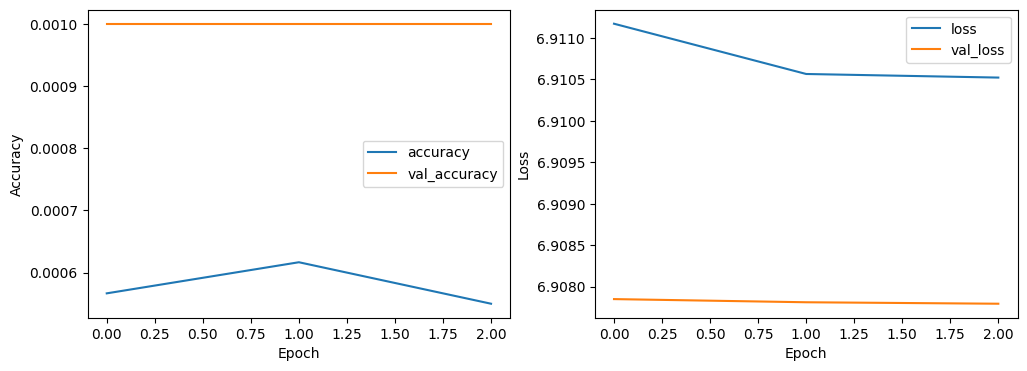

   conv_1_filter  conv_2_filter  dense_units  dropout_rate  learning_rate  \
0             96             96          128           0.4       0.001292   

   batch_size  
0          48  


In [18]:
# Section 15. Train on Full Dataset Without Validation Threshold

# Use the best hyperparameters for the full dataset
batch_size = best_hps.values.get('batch_size', 32)  # Properly retrieve the batch size with a default fallback

train_generator_full = train_datagen.flow_from_directory(
    full_train_dir,
    target_size=(84, 84),
    batch_size=batch_size,  # Use the resolved batch_size
    class_mode='categorical'
)

val_generator_full = val_datagen.flow_from_directory(
    full_val_dir,
    target_size=(84, 84),
    batch_size=batch_size,  # Use the resolved batch_size
    class_mode='categorical'
)

test_generator_full = test_datagen.flow_from_directory(
    full_test_dir,
    target_size=(84, 84),
    batch_size=batch_size,  # Use the resolved batch_size
    class_mode='categorical'
)

# Build and train the model with the best hyperparameters on the full dataset
best_model_full = tuner.hypermodel.build(best_hps)

# Modify the final layer to match the number of classes in the full dataset
best_model_full.pop()  # Remove the old final layer
best_model_full.add(Dense(train_generator_full.num_classes, activation='softmax'))  # Add a new layer with correct output size

best_model_full.compile(optimizer=Adam(learning_rate=best_hps.get('learning_rate')),
                        loss='categorical_crossentropy',
                        metrics=['accuracy'])

history_full = best_model_full.fit(
    train_generator_full,
    epochs=20,
    validation_data=val_generator_full,
    callbacks=[early_stopping]
)

# Evaluate the model on the full test data
test_loss_full, test_acc_full = best_model_full.evaluate(test_generator_full)
print(f"Test accuracy on full dataset: {test_acc_full}")

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_full.history['accuracy'], label='accuracy')
plt.plot(history_full.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_full.history['loss'], label='loss')
plt.plot(history_full.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Displaying the winning hyperparameters
best_hyperparameters_df = pd.DataFrame([{
    'conv_1_filter': best_hps.get('conv_1_filter'),
    'conv_2_filter': best_hps.get('conv_2_filter'),
    'dense_units': best_hps.get('dense_units'),
    'dropout_rate': best_hps.get('dropout_rate'),
    'learning_rate': best_hps.get('learning_rate'),
    'batch_size': batch_size  # Use the resolved batch size
}])
print(best_hyperparameters_df)
best_hyperparameters_df.to_csv('new_output/best_hyperparameters.csv', index=False)

### first  run **fail**

THESE ARE THE RESUTS - FULL DATASET RUN TERMINATES EARLY?

Found 60000 images belonging to 1000 classes.
Found 20000 images belonging to 1000 classes.
Found 20000 images belonging to 1000 classes.
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 32s 24ms/step - accuracy: 6.7152e-04 - loss: 6.9104 - val_accuracy: 0.0010 - val_loss: 6.9079
Epoch 2/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 28s 22ms/step - accuracy: 9.5357e-04 - loss: 6.9092 - val_accuracy: 0.0010 - val_loss: 6.9078
Epoch 3/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 28s 22ms/step - accuracy: 3.8044e-04 - loss: 6.9093 - val_accuracy: 0.0010 - val_loss: 6.9078
417/417 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.0010 - loss: 6.9078
Test accuracy on full dataset: 0.0010000000474974513


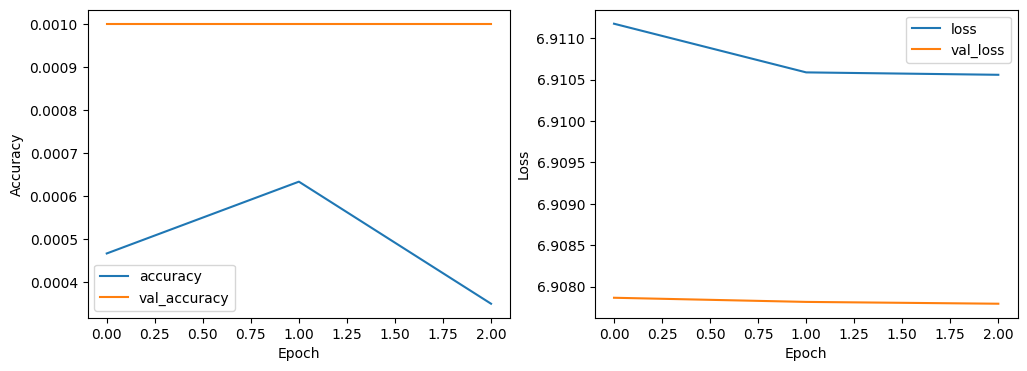

   conv_1_filter  conv_2_filter  dense_units  dropout_rate  learning_rate  \
0             96             96          128           0.4       0.001292   

   batch_size  
0          48  


In [19]:
# Section 15. Train on Full Dataset Without Validation Threshold
# Use the best hyperparameters for the full dataset
if 'batch_size' in best_hps.values:
    batch_size = best_hps.get('batch_size')
else:
    batch_size = 32  # Provide a default value of 32 if 'batch_size' is not in best_hps

train_generator_full = train_datagen.flow_from_directory(
    full_train_dir,
    target_size=(84, 84),
    batch_size=batch_size,  # Use the resolved batch_size
    class_mode='categorical'
)

val_generator_full = val_datagen.flow_from_directory(
    full_val_dir,
    target_size=(84, 84),
    batch_size=batch_size,  # Use the resolved batch_size
    class_mode='categorical'
)

test_generator_full = test_datagen.flow_from_directory(
    full_test_dir,
    target_size=(84, 84),
    batch_size=batch_size,  # Use the resolved batch_size
    class_mode='categorical'
)

# Build and train the model with the best hyperparameters on the full dataset
best_model_full = tuner.hypermodel.build(best_hps)

# Modify the final layer to match the number of classes in the full dataset
best_model_full.pop()  # Remove the old final layer
best_model_full.add(Dense(train_generator_full.num_classes, activation='softmax'))  # Add a new layer with correct output size

best_model_full.compile(optimizer=Adam(learning_rate=best_hps.get('learning_rate')),
                        loss='categorical_crossentropy',
                        metrics=['accuracy'])

history_full = best_model_full.fit(
    train_generator_full,
    epochs=20,
    validation_data=val_generator_full,
    callbacks=[early_stopping]
)

# Evaluate the model on the full test data
test_loss_full, test_acc_full = best_model_full.evaluate(test_generator_full)
print(f"Test accuracy on full dataset: {test_acc_full}")

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_full.history['accuracy'], label='accuracy')
plt.plot(history_full.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_full.history['loss'], label='loss')
plt.plot(history_full.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Displaying the winning hyperparameters
best_hyperparameters_df = pd.DataFrame([{
    'conv_1_filter': best_hps.get('conv_1_filter'),
    'conv_2_filter': best_hps.get('conv_2_filter'),
    'dense_units': best_hps.get('dense_units'),
    'dropout_rate': best_hps.get('dropout_rate'),
    'learning_rate': best_hps.get('learning_rate'),
    'batch_size': batch_size  # Use the resolved batch_size
}])
print(best_hyperparameters_df)
best_hyperparameters_df.to_csv('new_output/best_hyperparameters.csv', index=False)
